In [1]:
from shittynnet.tensor import Tensor
import numpy as np
from tqdm import tqdm

# Two bin net

Super-simple network that sorts 2-vectors into two categories

## Generate train and test data

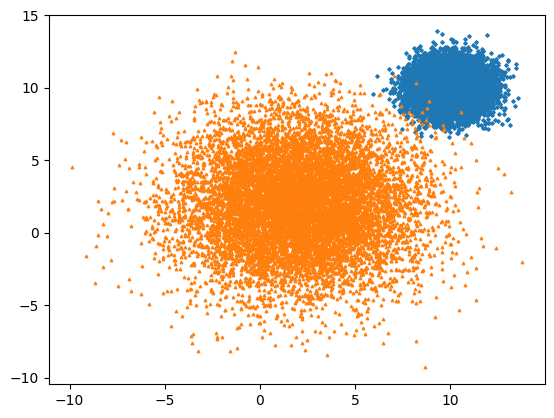

In [2]:
# Generate two categories of x,y data
rng = np.random.default_rng(1337) # reproducibly
x1 = rng.normal(10, 1, size=(10000,2))
x2 = rng.normal(2, 3, size=(10000,2))

import matplotlib.pyplot as plt
plt.scatter(x1.T[0], x1.T[1], marker="D", s=3)
plt.scatter(x2.T[0], x2.T[1], marker='^', s=3)


In [3]:
def unison_shuffle(a, b, seed=None):
  assert len(a) == len(b), "Lengths of arrays for shuffle don't match"
  p = np.random.default_rng(seed).permutation(len(a))
  return a[p], b[p]

In [4]:
# data
x_t = np.concatenate((x1[:9000],x2[:9000]))
x_v = np.concatenate((x1[-1000:],x2[-1000:]))
# labels
y_t = np.concatenate((np.zeros(9000), np.ones(9000)))
y_v = np.concatenate((np.zeros(1000), np.ones(1000)))

x_train, y_train = unison_shuffle(x_t, y_t, seed=0xB00B)
x_test, y_test = unison_shuffle(x_v, y_v, seed=0xF00D)

# Model

In [5]:
class twobinnet:
    def __init__(self):
      self.L1 = Tensor.uniform((2,2))
      self.L1b = Tensor.uniform((1,2))
      self.L2 = Tensor.uniform((2,1))
      self.L2b = Tensor.uniform((1,1))
    def forward(self, x):
      out = x.dot(self.L1)
      out = out + self.L1b
      out = out.relu()
      out = out.dot(self.L2)
      out = out + self.L2b
      out = out.sigm()
      return out
    
lol = twobinnet()

## Train by hand

in minibatches of 100, over 100 epochs

In [6]:
# super-dumb optimizer
LEARN_STEP = 0.001
MBATCH_SIZE = 100
# EPOCH = 100 # ~6 minutes, gets you 1 or none wrong out of 2000 validation points
EPOCH = 10 # ~30 seconds, gets you 9 wrong

updates_per_epoch = len(x_train)//MBATCH_SIZE

for e in range(EPOCH):
    glob_counter = 0
    acc_loss = 0.
    for _ in tqdm(range(updates_per_epoch)):
      # calcualate grad in minibatches
      for n in range(glob_counter, glob_counter + MBATCH_SIZE):
        loss = (lol.forward(Tensor(x_train[n])) - y_train[n])**2
        acc_loss += loss.data
        loss.backward()

      glob_counter += MBATCH_SIZE
    
      # learn
      lol.L1.data = lol.L1.data - lol.L1.grad * LEARN_STEP
      lol.L1b.data = lol.L1b.data - lol.L1b.grad * LEARN_STEP
      lol.L2.data = lol.L2.data - lol.L2.grad * LEARN_STEP
      lol.L2b.data = lol.L2b.data - lol.L2b.grad * LEARN_STEP

      # zero out grad
      lol.L1._zero_grad()
      lol.L1b._zero_grad()
      lol.L2._zero_grad()
      lol.L2b._zero_grad()
    print(f"average loss in the {e} epoch: {acc_loss/(updates_per_epoch * MBATCH_SIZE)}")

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:03<00:00, 51.49it/s]


average loss in the 0 epoch: [[0.08228929]]


100%|██████████| 180/180 [00:03<00:00, 50.23it/s]


average loss in the 1 epoch: [[0.03305402]]


100%|██████████| 180/180 [00:04<00:00, 38.90it/s]


average loss in the 2 epoch: [[0.02205848]]


100%|██████████| 180/180 [00:04<00:00, 39.24it/s]


average loss in the 3 epoch: [[0.01683423]]


100%|██████████| 180/180 [00:03<00:00, 59.99it/s]


average loss in the 4 epoch: [[0.01378371]]


100%|██████████| 180/180 [00:03<00:00, 46.97it/s]


average loss in the 5 epoch: [[0.01178388]]


100%|██████████| 180/180 [00:04<00:00, 44.26it/s]


average loss in the 6 epoch: [[0.01036973]]


100%|██████████| 180/180 [00:02<00:00, 61.79it/s]


average loss in the 7 epoch: [[0.00931628]]


100%|██████████| 180/180 [00:02<00:00, 60.42it/s]


average loss in the 8 epoch: [[0.00850054]]


100%|██████████| 180/180 [00:03<00:00, 46.43it/s]

average loss in the 9 epoch: [[0.00784907]]


## Evaluate

In [7]:
wrong = 0
for x in range(len(x_test)):
  model = lol.forward(Tensor(x_test[x])).data
  answer = 1 if model > 0.5 else 0
  if answer != y_test[x]:
    wrong += 1

print(f"got {wrong} wrong out of {len(x_test)} validation examples")

got 5 wrong out of 2000 validation examples
